In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [229]:
from google.colab import drive
drive.mount('/content/gdrive') 

ImportError: No module named 'google.colab'

In [230]:
#connecting to sqlite db
# con = sqlite3.connect('/content/gdrive/My Drive/Colab Notebooks/Assignment 4/database.sqlite')
con = sqlite3.connect('database.sqlite')
                      
# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [231]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [232]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [233]:
# Removing duplicate reviews
final=filtered_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
print(final.shape)

(364173, 10)


In [234]:
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [235]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [236]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

In [237]:
final["cleanReview"] = final["Summary"].map(str) + ". " + final["Text"]

In [238]:
final['cleanReview'].head()

0    Good Quality Dog Food. I have bought several o...
1    Not as Advertised. Product arrived labeled as ...
2    "Delight" says it all. This is a confection th...
3    Cough Medicine. If you are looking for the sec...
4    Great taffy. Great taffy at a great price.  Th...
Name: cleanReview, dtype: object

In [239]:
final['lengthOfReview'] = final['cleanReview'].str.split().str.len()
final['lengthOfReview'].head()

0    52
1    34
2    98
3    43
4    29
Name: lengthOfReview, dtype: int64

In [19]:
#remove urls from text python
from tqdm import tqdm
lst = []
removed_urls_list = []
for text in tqdm(final['cleanReview']):
  removed_urls_text = re.sub(r"http\S+", "", text)
  lst.append(removed_urls_text)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 364171/364171 [00:01<00:00, 348689.13it/s]


In [20]:
#remove urls from text python
removed_urls_list = []
for text in tqdm(lst):
  removed_urls_text = re.sub(r"http\S+", "", text)
  removed_urls_list.append(removed_urls_text)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 364171/364171 [00:00<00:00, 545983.46it/s]


In [21]:
from bs4 import BeautifulSoup
text_lst = []
for text in tqdm(removed_urls_list):
  soup = BeautifulSoup(text, 'lxml')
  text = soup.get_text()
  text_lst.append(text)
# print(text)
# print("="*50)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 364171/364171 [02:07<00:00, 2863.46it/s]


In [22]:
print(len(final['cleanReview']))

364171


In [23]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [24]:
decat_lst = []
for decat_text in tqdm(text_lst):
  text = decontracted(decat_text)
  decat_lst.append(text)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 364171/364171 [00:05<00:00, 67496.57it/s]


In [25]:
strip_list = []
for to_strip in tqdm(decat_lst):
  text = re.sub("\S*\d\S*", "", to_strip).strip()
  strip_list.append(text)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 364171/364171 [00:19<00:00, 18494.66it/s]


In [26]:
spatial_list = []
for to_spatial in tqdm(strip_list):
  text = re.sub('[^A-Za-z0-9]+', ' ', to_spatial)
  spatial_list.append(text)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 364171/364171 [00:09<00:00, 36464.50it/s]


In [27]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [28]:
# Combining all the above stundents 
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(spatial_list):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 364171/364171 [02:01<00:00, 2999.66it/s]


In [29]:
print(len(preprocessed_reviews))
preprocessed_reviews[-1]

364171


'great honey satisfied product advertised use cereal raw vinegar general sweetner'

In [30]:
final['cleanReview'] = preprocessed_reviews

In [117]:
print(len(final))
final.tail(5)

364171


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleanReview,lengthOfReview
525809,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,1,1299628800,Will not do without,Great for sesame chicken..this is a good if no...,not without great sesame chicken good not bett...,15
525810,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,0,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...,disappointed disappointed flavor chocolate not...,24
525811,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,1,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o...",perfect maltipoo stars small give one training...,40
525812,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,1,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...,favorite training reward treat best treats tra...,22
525813,568454,B001LR2CU2,A3LGQPJCZVL9UC,srfell17,0,0,1,1338422400,Great Honey,"I am very satisfied ,product is as advertised,...",great honey satisfied product advertised use c...,11


In [118]:
final['cleanReview'][0]

'good quality dog food bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better'

In [119]:
final['lengthOfReview'][0]

27

In [3]:
dir_path = os.getcwd()
# conn = sqlite3.connect(os.path.join(dir_path, '/content/gdrive/My Drive/Colab Notebooks/Assignment 4/final.sqlite'))
conn = sqlite3.connect(os.path.join(dir_path, 'final.sqlite'))
# final.to_sql('Reviews', conn, if_exists='replace', index=False)

In [4]:
review_3 = pd.read_sql_query(""" SELECT count(*) FROM Reviews""", conn)
print(review_3)

   count(*)
0    364171


In [5]:
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews""", conn)

In [6]:
filtered_data.shape

(364171, 13)

In [7]:
filtered_data["Time"] = pd.to_datetime(filtered_data["Time"], unit = "s")
filtered_data = filtered_data.sort_values(by = "Time")

In [8]:
filtered_data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleanReview,lengthOfReview,Preprocessed_text
117924,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,1999-10-08,EVERY book is educational,this witty little book makes my son laugh at l...,EVERY book is educational. this witty little b...,78,witty little book makes son laugh loud recite ...
117901,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,1999-10-25,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,This whole series is great way to spend time w...,90,remember seeing show aired television years ag...
298792,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,1999-12-02,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,Entertainingl Funny!. Beetlejuice is a well wr...,31,beetlejuice well written movie everything exce...
169281,230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,1,1999-12-06,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",A modern day fairy tale. A twist of rumplestis...,41,twist rumplestiskin captured film starring mic...
298791,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,2000-01-03,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,FANTASTIC!. Beetlejuice is an excellent and fu...,44,beetlejuice excellent funny movie keaton hilar...


In [9]:
print(len(filtered_data))
filtered_data.info()
filtered_data = filtered_data.head(100000)
print(len(filtered_data))

364171
<class 'pandas.core.frame.DataFrame'>
Int64Index: 364171 entries, 117924 to 107253
Data columns (total 13 columns):
Id                        364171 non-null int64
ProductId                 364171 non-null object
UserId                    364171 non-null object
ProfileName               364171 non-null object
HelpfulnessNumerator      364171 non-null int64
HelpfulnessDenominator    364171 non-null int64
Score                     364171 non-null int64
Time                      364171 non-null datetime64[ns]
Summary                   364171 non-null object
Text                      364171 non-null object
cleanReview               364171 non-null object
lengthOfReview            364171 non-null int64
Preprocessed_text         364171 non-null object
dtypes: datetime64[ns](1), int64(5), object(7)
memory usage: 38.9+ MB
100000


In [10]:
filtered_data['Score'].value_counts()

1    87729
0    12271
Name: Score, dtype: int64

In [11]:
X = filtered_data["cleanReview"]
print(print("shape of X:", X.head(5)))
y = filtered_data["Score"]
print("shape of y:", y.head(5))
X_len = filtered_data['lengthOfReview']

shape of X: 117924    EVERY book is educational. this witty little b...
117901    This whole series is great way to spend time w...
298792    Entertainingl Funny!. Beetlejuice is a well wr...
169281    A modern day fairy tale. A twist of rumplestis...
298791    FANTASTIC!. Beetlejuice is an excellent and fu...
Name: cleanReview, dtype: object
None
shape of y: 117924    1
117901    1
298792    1
169281    1
298791    1
Name: Score, dtype: int64


In [12]:
len(filtered_data['lengthOfReview'])

100000

In [13]:
X_train = X[0:100000]
Y_train = y[0:100000]

In [14]:
print(len(X_train))
print(len(Y_train))

100000
100000


In [15]:
print(X_train.shape)
print(X_train.shape)

(100000,)
(100000,)


### 

# Bag of Words

In [15]:
from sklearn.feature_extraction.text import CountVectorizer 

count_vect = CountVectorizer()
X_train_vect = count_vect.fit_transform(X_train)
X_test_vect = count_vect.transform(X_test)
X_val_vect = count_vect.transform(X_val)
feature_names = count_vect.get_feature_names()
# BoW_dict = {'X_train_vect':X_train_vect, 'X_test_vect': X_test_vect, 'X_val_vect': X_val_vect}
print(X_train_vect.shape)
# print(feature_names)

(60000, 48270)


In [16]:
X_train_vect.shape

(60000, 48270)

In [18]:
len(filtered_data['lengthOfReview'])

100000

In [191]:
from scipy.sparse import hstack
# len_review = final['lengthOfReview'].to_sparse()
concat_data = hstack((X_train_vect,np.array(filtered_data['lengthOfReview'][0:60000])[:,None]))
concat_data_val = hstack((X_val_vect,np.array(filtered_data['lengthOfReview'][60000:80000])[:,None]))
concat_data_test = hstack((X_test_vect,np.array(filtered_data['lengthOfReview'][80000:100000])[:,None]))

In [193]:
print(concat_data.shape)
print(concat_data_val.shape)
print(concat_data_test.shape)

(60000, 47536)
(20000, 47536)
(20000, 47536)


In [194]:
print(len(feature_names))

47535


In [195]:
BoW_dict = {'X_train_vect':concat_data, 'X_test_vect': concat_data_test, 'X_val_vect': concat_data_val}
print(BoW_dict['X_train_vect'].shape)

(60000, 47536)


In [196]:
import pickle
with open('BoW.pkl', 'wb') as handle:
    pickle.dump(BoW_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

## TF-IDF

In [24]:
tf_idf_vect = TfidfVectorizer(min_df=10)
train_tf_idf = tf_idf_vect.fit_transform(X_train)

print("the shape of out text TFIDF vectorizer ",train_tf_idf.get_shape())
print("the type of count vectorizer ",type(train_tf_idf))
print("the number of unique words including both unigrams and bigrams ", train_tf_idf.get_shape()[1])

the shape of out text TFIDF vectorizer  (100000, 13374)
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the number of unique words including both unigrams and bigrams  13374


In [19]:
tf_idf_dict = {'train_tf_idf': train_tf_idf}

In [19]:
import pickle
with open('tf_idf.pkl', 'wb') as handle:
    pickle.dump(tf_idf_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

## TruncatedSVD on tfidf

In [16]:
import pickle
# with open(r"/content/gdrive/My Drive/Colab Notebooks/Assignment 4/tf_idf.pkl", "rb") as input_file:
with open(r"tf_idf.pkl", "rb") as input_file:
    tfidf_dict = pickle.load(input_file)

In [18]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD()
svd.fit(tfidf_dict['train_tf_idf'])

TruncatedSVD(algorithm='randomized', n_components=2, n_iter=5,
       random_state=None, tol=0.0)

In [25]:
y = dict(zip(tf_idf_vect.get_feature_names(), tf_idf_vect.idf_))

In [27]:
from collections import OrderedDict
from operator import itemgetter

sorted_dict = OrderedDict(sorted(y.items(), key = itemgetter(1), reverse=True))

In [28]:
top_features = list(sorted_dict)[:2000]

In [29]:
print(len(top_features))
top_features[0]

2000


'enlightening'

In [30]:
top_features

['enlightening',
 'gnc',
 'bays',
 'survives',
 '320',
 'singapore',
 'inaccurate',
 'courses',
 'baggy',
 'yucca',
 'yelling',
 'gingersnaps',
 'steroids',
 'meatball',
 'carrs',
 'curled',
 'conspiracy',
 'yankee',
 'hippie',
 'parthenon',
 'crime',
 'swings',
 'putrid',
 'kukicha',
 'stuffy',
 'grazing',
 'checkup',
 'cheeper',
 'meter',
 'doggone',
 'primo',
 'testament',
 'chiropractor',
 'skyline',
 'pluses',
 'lighten',
 'grrrreat',
 'tampered',
 'mtn',
 'rubbish',
 'arnold',
 'ethically',
 'cruel',
 'collapse',
 'actor',
 '1987',
 'turtles',
 'shooting',
 'advent',
 'seperately',
 'kirsch',
 'usualy',
 'gourment',
 'farmhouse',
 'scarlet',
 'loser',
 'deb',
 'unto',
 'macho',
 'wishlist',
 'accepts',
 'senna',
 'sparked',
 'achievement',
 'bison',
 'athletic',
 'africans',
 'folds',
 'super5mix',
 'chaser',
 'tahitian',
 'acetate',
 'wrappings',
 'bisto',
 'dinty',
 'smother',
 'mmmmmmmmmm',
 'harsher',
 'tso',
 'keenwa',
 'breeders',
 'clark',
 'injured',
 'corp',
 'pointless'

In [32]:
covariace_mat = np.array([[0 for x in range(2000)] for x in range(2000)])
index_col=top_features[:3000]

cov_df=pd.DataFrame(covariace_mat,index=index_col,columns=index_col)
for sentance in tqdm(X_train):
    words=sentance.split(" ")
    for i in range(len(words)):               
        for j in range(i-4,i+5):           
            if(j>=0 and j<len(words)):
                if(words[i] in index_col and words[j] in index_col):
                    cov_df.loc[words[i], words[j]] += 1 

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [58:29<00:00, 33.29it/s]


In [33]:
cov_df

,enlightening,gnc,bays,survives,320,singapore,inaccurate,courses,baggy,yucca,...,blanc,driveway,yogart,exp,happybellies,earthiness,antioxidents,batteries,vons,wolfs
enlightening,10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
gnc,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
bays,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
survives,0,0,0,8,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
320,0,0,0,0,6,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
singapore,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
inaccurate,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
courses,0,0,0,0,0,0,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0
baggy,0,0,0,0,0,0,0,0,6,0,...,0,0,0,0,0,0,0,0,0,0
yucca,0,0,0,0,0,0,0,0,0,8,...,0,0,0,0,0,0,0,0,0,0


In [34]:
cov_df.shape

(2000, 2000)

In [55]:
tsvd_dict = {}
for i in range(1, 200):
    tsvd = TruncatedSVD(n_components=i).fit(cov_df)
    tsvd_dict[i] = tsvd

In [56]:
tsvd_dict[1]

TruncatedSVD(algorithm='randomized', n_components=1, n_iter=5,
       random_state=None, tol=0.0)

In [58]:
var_list = []
for i in range(1, 200):
    tsvd_dict[i].explained_variance_ratio_
    var_list.append(tsvd_dict[i].explained_variance_ratio_)

In [59]:
tsvd_dict[99].explained_variance_ratio_

array([0.00778991, 0.00466505, 0.00418924, 0.00254148, 0.0025004 ,
       0.00250077, 0.00233654, 0.00221247, 0.00221309, 0.00221312,
       0.00221262, 0.00213429, 0.00212707, 0.00202014, 0.0019414 ,
       0.00194181, 0.001937  , 0.00193533, 0.00184859, 0.00181679,
       0.00177312, 0.001706  , 0.00169987, 0.00168473, 0.00168105,
       0.00168221, 0.00167847, 0.00167694, 0.00167337, 0.00166471,
       0.00165965, 0.00165612, 0.00165026, 0.00162001, 0.00157216,
       0.00152761, 0.00150226, 0.00146243, 0.00146492, 0.00146089,
       0.00145585, 0.00144754, 0.00144451, 0.00144027, 0.00143942,
       0.00143739, 0.00143347, 0.00143174, 0.00142855, 0.00142752,
       0.00142514, 0.00141985, 0.00141961, 0.00141425, 0.00140997,
       0.00140934, 0.00140099, 0.00139658, 0.00138883, 0.00138431,
       0.00138439, 0.00137788, 0.00137333, 0.00136507, 0.00135657,
       0.00134708, 0.00133324, 0.00132756, 0.00130612, 0.00129913,
       0.00128259, 0.00127098, 0.00126521, 0.00125099, 0.00124

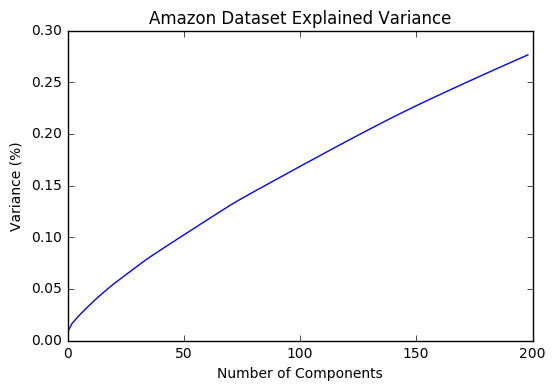

In [61]:
plt.figure()
plt.plot(np.cumsum(tsvd_dict[199].explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Amazon Dataset Explained Variance')
plt.show()